# TimeSeries Project (e-commerce dataset)

Problems encountered in dataset:
- Columns separated with character (')
- Float separated with comma 
- Totale column with negative values

In [396]:
# Utils
import pandas as pd
import numpy as np
import itertools

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# Dates
from datetime import timedelta, date
from functools import partial
from time import sleep
from calendar import monthrange

# Google trends
from pytrends.exceptions import ResponseError
from pytrends.request import TrendReq

# Time series
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import pmdarima as pm

## Import dataset and formatting types

In [397]:
df = pd.read_csv('.\data\serie-storiche-ecommerce.csv', quotechar="'", parse_dates=["data"])
df["totale"] = df["totale"].apply(lambda x : (x.replace(",", ".")))
df["totale"] = df["totale"].astype(float)
df.sort_values('data', inplace=True)
df.head()

,data,totale,settore
0,2013-02-01,815.97,Calcio
1,2013-02-21,4775.75,Fitness
2,2013-04-01,4775.75,Fitness
3,2013-04-06,1962.15,Casual
4,2013-07-09,1809.87,Basket


In [398]:
### descriptive analysis on total column
df["totale"].describe()

count     25261.000000
mean       7886.239314
std       13273.856514
min       -2159.180000
25%        1335.300000
50%        3948.860000
75%       10209.730000
max      516104.930000
Name: totale, dtype: float64

In [399]:
df.isnull().sum()

data       0
totale     0
settore    0
dtype: int64

In [400]:
df = df[df["totale"]>0]

## Data exploration

In [401]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25227 entries, 0 to 25260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     25227 non-null  datetime64[ns]
 1   totale   25227 non-null  float64       
 2   settore  25227 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 788.3+ KB


In [402]:
### descriptive analysis on total column
df["totale"].describe()

count     25227.000000
mean       7896.953680
std       13279.580998
min           0.270000
25%        1337.210000
50%        3966.870000
75%       10224.470000
max      516104.930000
Name: totale, dtype: float64

In [403]:
### Check for missing days

### Group by per data to sum total earnings
df_sells_day = pd.DataFrame(df.groupby(by="data", sort=True, as_index=False)["totale"].sum())

list_missing_dates = []
previous_date = df_sells_day['data'][0] - timedelta(days=1)
for dates in df_sells_day['data']:
    if dates-timedelta(days=1) != previous_date:
        list_missing_dates.append(dates)
    previous_date = dates

print('Last date with missing previous day: ' + str(list_missing_dates[-1]))

Last date with missing previous day: 2014-02-20 00:00:00


In [404]:
### Keep only days after the 2014-02-20 and discard the last day too (very low value, could be partial data, maybe extracted not at the end of the day)
df_sells_day = df_sells_day[(df_sells_day['data'] > '2014-02-20') & (df_sells_day['data'] < '2022-04-01')]

Text(0, 0.5, 'Vendite [€]')

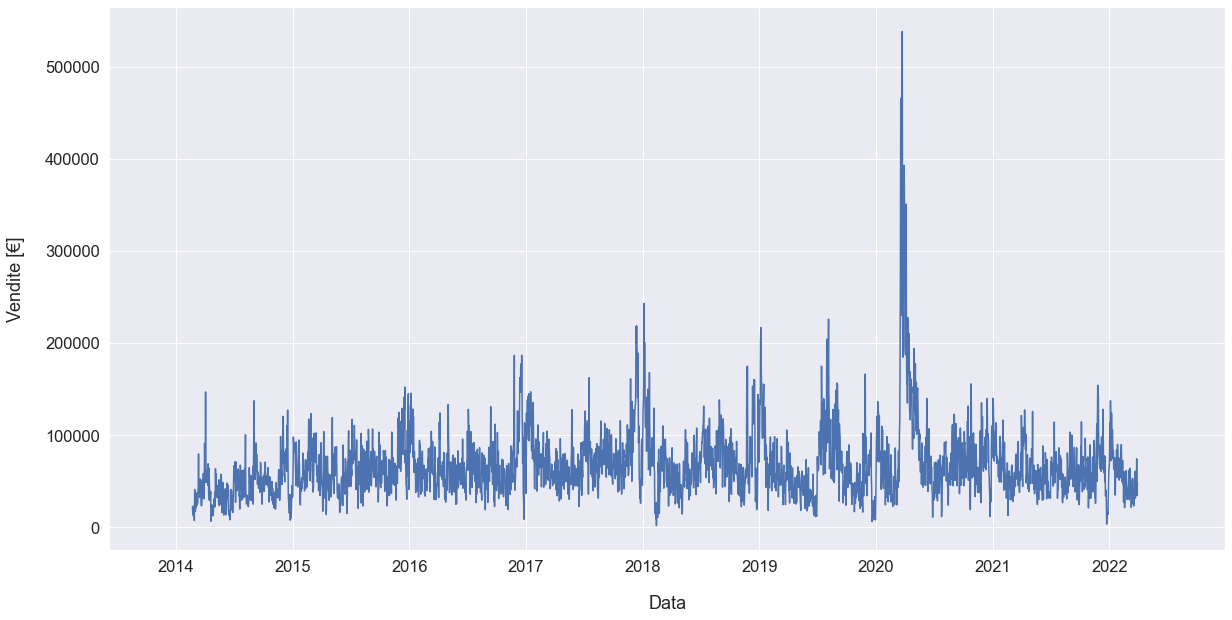

In [405]:
### Plot daily sells
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(20,10))
df_sells_day.plot(x='data', y='totale', ax=ax, legend=False)
plt.xlim(left='2013-06-06', right='2022-12-31')
plt.xlabel('Data', labelpad=20)
plt.ylabel('Vendite [€]', labelpad=20)

Text(0, 0.5, 'Vendite [€]')

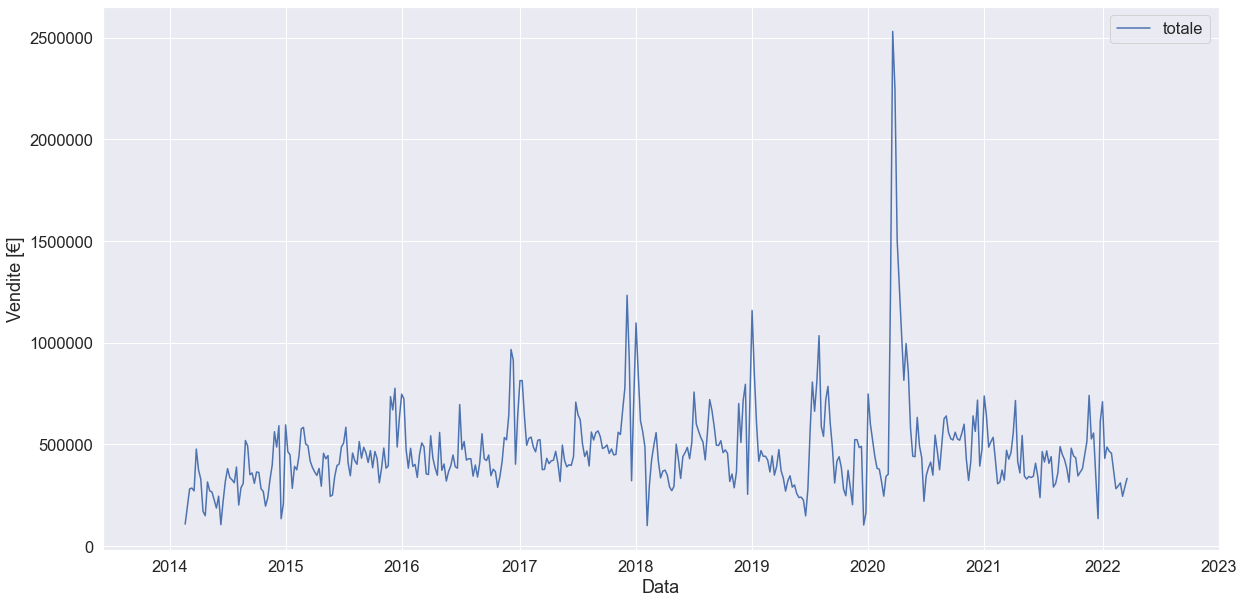

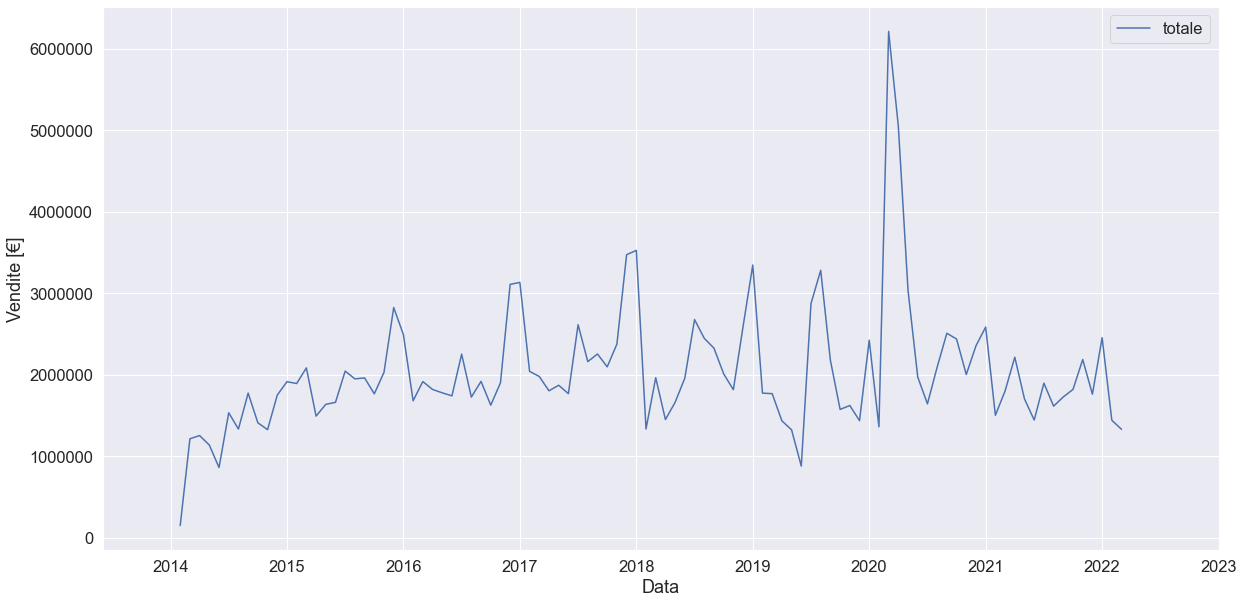

In [406]:
### Group by per data to sum total earnings (1 week and 1 month timeslice)
plt.rcParams["figure.figsize"] = (20,10)

# 1 week sum
df_sells_week = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='7d'))['totale'].sum()).reset_index('data')
df_sells_week.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.xlabel('Data')
plt.ylabel('Vendite [€]')

# 1 month sum
df_sells_month = pd.DataFrame(df_sells_day.groupby(pd.Grouper(key='data', freq='1m'))['totale'].sum()).reset_index('data')
df_sells_month.plot(x='data', y='totale')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.xlabel('Data')
plt.ylabel('Vendite [€]')

In [407]:
### Pivot by month
df_sells_day['anno'] = [d.year for d in df_sells_day['data']]
df_sells_day['mese'] = [d.month for d in df_sells_day['data']]

df_pivot_month = pd.DataFrame(df_sells_day.groupby(by=['anno', 'mese'])['totale'].sum()).reset_index()
df_pivot_month = df_pivot_month.pivot(index="mese", columns="anno", values="totale")
df_pivot_month.describe()

anno,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,3.000000e+00
mean,1.249578e+06,1.938444e+06,1.997196e+06,2.298046e+06,2.147691e+06,1.957926e+06,2.758411e+06,1.855226e+06,1.742187e+06
std,4.496960e+05,3.339884e+05,4.291439e+05,5.327952e+05,6.092255e+05,7.983349e+05,1.431321e+06,3.273135e+05,6.193382e+05
min,1.488231e+05,1.492607e+06,1.627219e+06,1.768157e+06,1.334476e+06,8.785999e+05,1.361682e+06,1.444479e+06,1.330307e+06
25%,1.175879e+06,1.740015e+06,1.737415e+06,1.952222e+06,1.778270e+06,1.436306e+06,1.995257e+06,1.681110e+06,1.386064e+06
50%,1.325950e+06,1.932309e+06,1.860432e+06,2.129405e+06,1.988325e+06,1.695611e+06,2.389943e+06,1.781493e+06,1.441821e+06
75%,1.472324e+06,2.034131e+06,2.002596e+06,2.436196e+06,2.483887e+06,2.350911e+06,2.641094e+06,1.969583e+06,1.948127e+06
max,1.774890e+06,2.825318e+06,3.109826e+06,3.473589e+06,3.526956e+06,3.347046e+06,6.214672e+06,2.585867e+06,2.454433e+06


Text(0, 0.5, 'Vendite [€]')

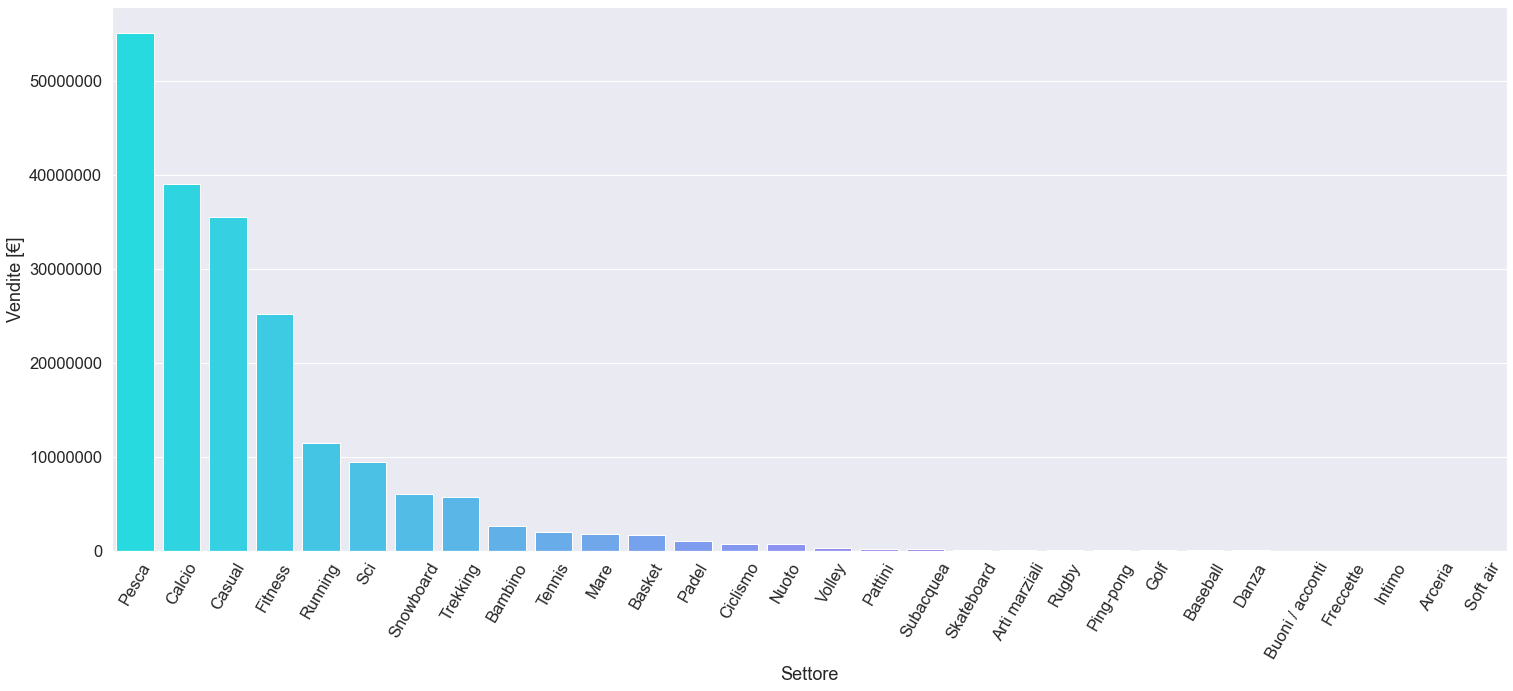

In [408]:
### Group by per category and sum up
df_groupby_settore = df.groupby(by=["settore"], sort=True)["totale"].sum().sort_values(ascending=False)
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
sns.barplot(x=list(df_groupby_settore.index), y=list(df_groupby_settore.values), palette="cool")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Settore')
plt.ylabel('Vendite [€]')


In [409]:
df.groupby(by=["settore"], sort=True)["totale"].sum().sort_values(ascending=False)

settore
Pesca              55076428.86
Calcio             39063769.07
Casual             35470317.90
Fitness            25187121.54
Running            11447753.44
Sci                 9481041.68
Snowboard           5993040.01
Trekking            5698905.14
Bambino             2603804.59
Tennis              1982250.43
Mare                1815919.63
Basket              1653939.28
Padel                991393.13
Ciclismo             743015.30
Nuoto                738166.35
Volley               312939.59
Pattini              198161.83
Subacquea            195149.72
Skateboard           119915.15
Arti marziali        105739.69
Rugby                 87701.16
Ping-pong             75427.11
Golf                  74456.72
Baseball              27796.47
Danza                 27136.40
Buoni / acconti       19103.00
Freccette             16336.32
Intimo                 5949.22
Arceria                3635.31
Soft air                136.45
Name: totale, dtype: float64

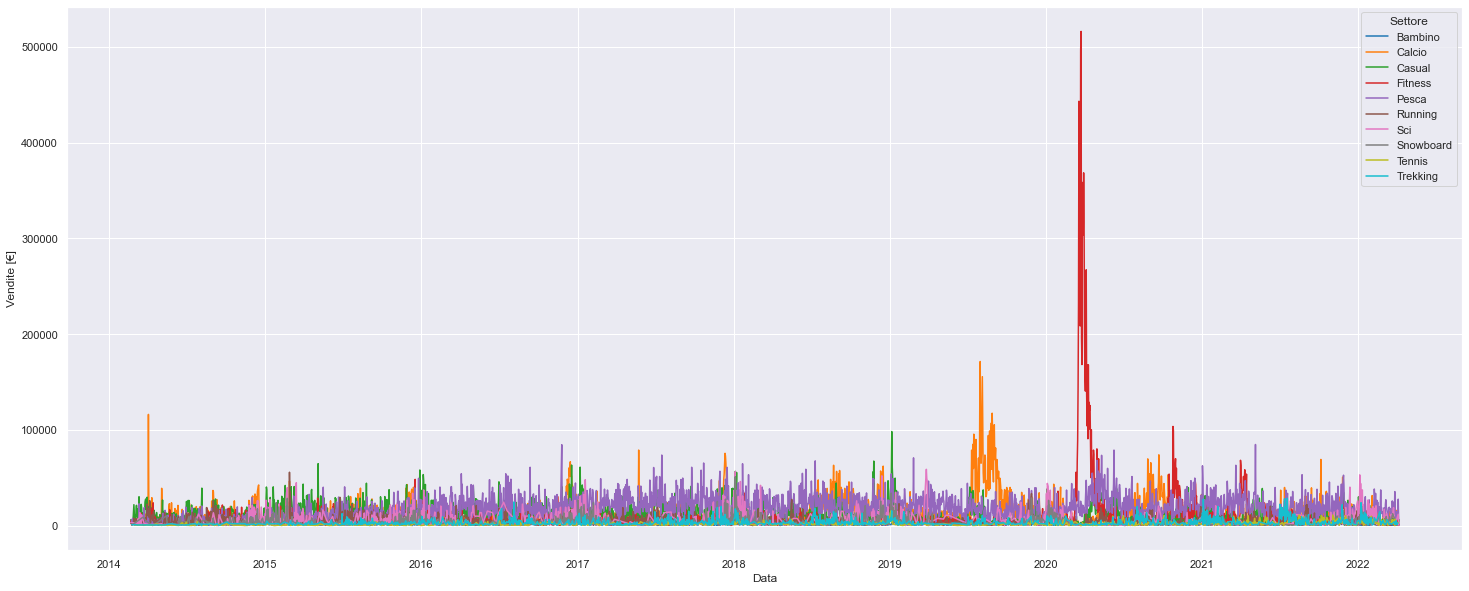

In [410]:
### time series group by higher sectors in total 
sns.set(font_scale = 1)
list_high_number_total = df_groupby_settore.index[0:10]
df_pivot_settore_and_data = (df[(df['data'] > '2014-02-20') & (df['data'] < '2022-04-08')].query("settore in @list_high_number_total")).pivot(index="data", columns="settore", values="totale")
plt.figure(figsize=(25,10))
sns.lineplot(data=df_pivot_settore_and_data, dashes=False, palette="tab10")
plt.xlabel('Data')
plt.ylabel('Vendite [€]')
plt.legend(title='Settore')


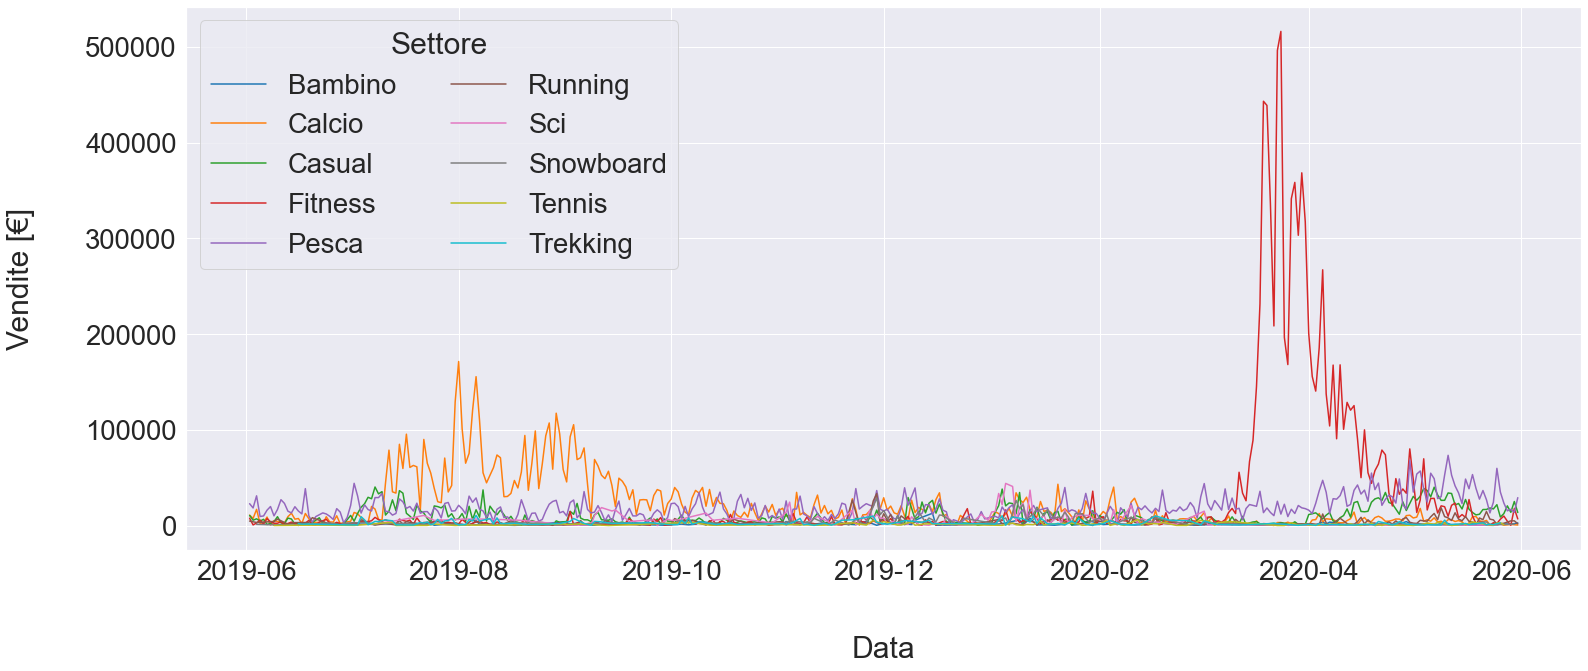

In [411]:
sns.set(font_scale = 2.5)
plt.figure(figsize=(25,10))
ax = sns.lineplot(data=df_pivot_settore_and_data[(df_pivot_settore_and_data.index > '2019-06-01') & (df_pivot_settore_and_data.index < '2020-06-01')], dashes=False, palette="tab10")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Data', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.legend(title='Settore', loc='upper left', ncol=2)

In [412]:
df_pivot_settore_and_data.describe()

settore,Bambino,Calcio,Casual,Fitness,Pesca,Running,Sci,Snowboard,Tennis,Trekking
count,1249.000000,2925.000000,2873.000000,2814.000000,2948.000000,2220.000000,1196.000000,1366.000000,972.000000,1514.000000
mean,2084.029736,13309.391921,12305.651730,8930.101446,18643.251957,5126.232239,7872.570886,4355.605007,2039.352294,3764.138137
std,2173.208435,13945.831456,9170.503593,28033.950556,11502.796926,4260.194013,8419.277251,4994.947934,2054.405058,3661.227758
min,81.870000,106.430000,162.100000,45.440000,36.840000,0.270000,2.730000,95.520000,36.840000,121.440000
25%,762.210000,5262.600000,5730.900000,2372.595000,10244.667500,2292.292500,1756.252500,1135.260000,614.030000,1335.300000
50%,1361.770000,9493.650000,10315.620000,4356.575000,16990.345000,3929.760000,5387.050000,2464.970000,1397.930000,2524.870000
75%,2677.150000,16000.400000,16511.810000,7788.430000,25198.020000,6871.755000,10902.360000,5645.072500,2863.402500,4947.202500
max,25858.090000,171365.370000,98255.460000,516104.930000,84700.250000,55733.000000,58780.480000,50980.720000,15268.760000,28574.540000


Text(0, 0.5, 'Vendite totali [€]')

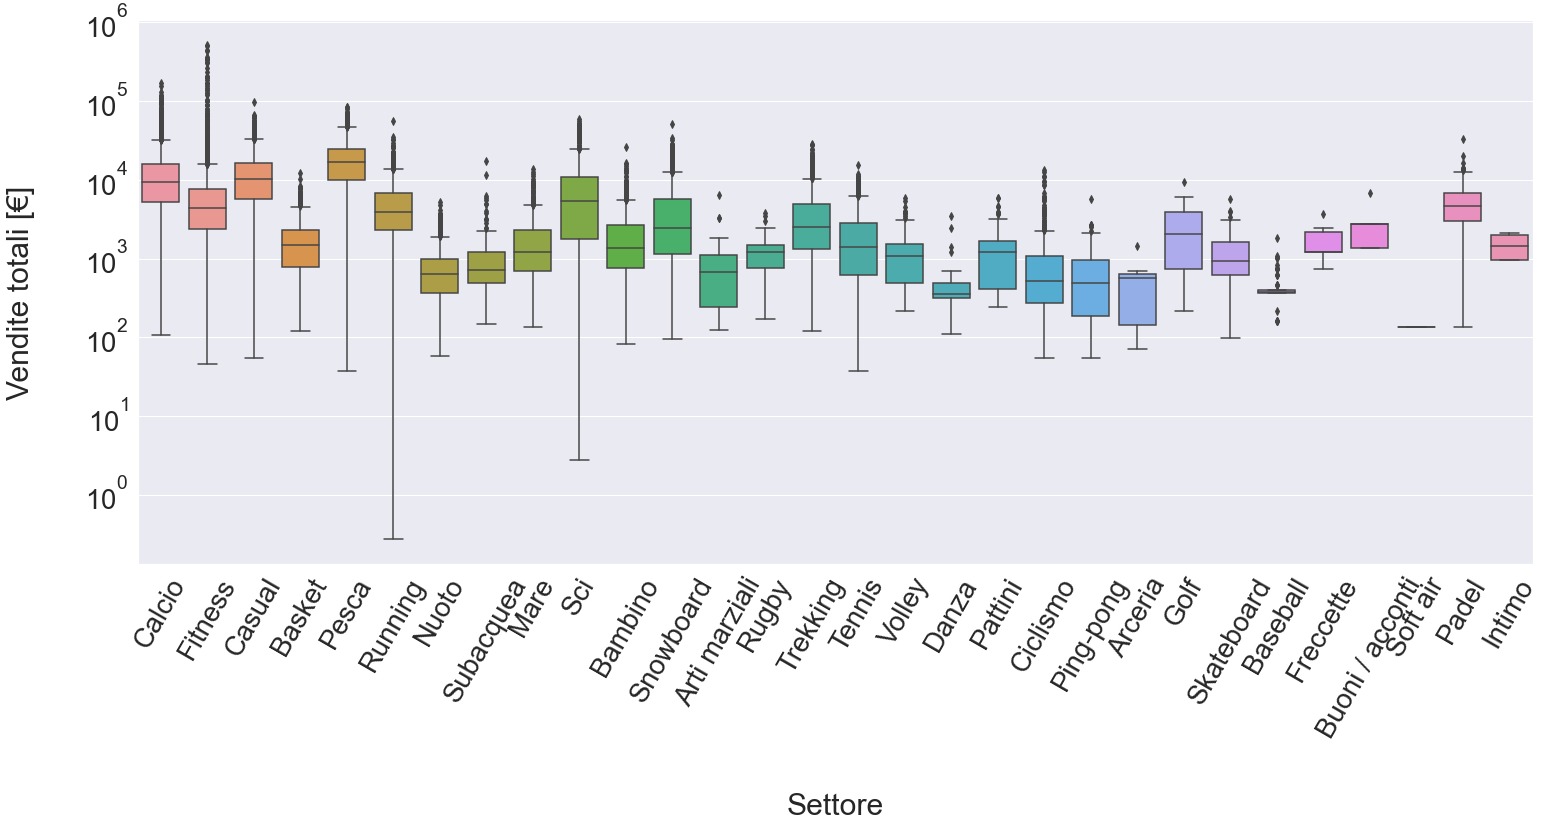

In [413]:
### boxplot to see correlation between cost spent and category
plt.figure(figsize=(25,10))
plt.xticks(rotation=60)
plot = sns.boxplot(data=df, x="settore", y="totale")
plot.set_yscale("log")
plt.xlabel('Settore', labelpad=50)
plt.ylabel('Vendite totali [€]', labelpad=50)

## Data integration
In this section, we decided to import data regarding the number of searches performed in the given period, in Italy, related to the fitness category. This is because we thought it was interesting to show a correlation between the number of sales and the number of searches on google

In [414]:
def get_last_date_of_month(year: int, month: int) -> date:
    """Given a year and a month returns an instance of the date class
    containing the last day of the corresponding month.
    Source: https://stackoverflow.com/questions/42950/get-last-day-of-the-month-in-python
    """
    return date(year, month, monthrange(year, month)[1])


def convert_dates_to_timeframe(start: date, stop: date) -> str:
    """Given two dates, returns a stringified version of the interval between
    the two dates which is used to retrieve data for a specific time frame
    from Google Trends.
    """
    return f"{start.strftime('%Y-%m-%d')} {stop.strftime('%Y-%m-%d')}"


def _fetch_data(pytrends, build_payload, timeframe: str) -> pd.DataFrame:
    """Attempts to fecth data and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            build_payload(timeframe=timeframe)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return pytrends.interest_over_time()


def get_daily_data(word: str,
                 start_year: int,
                 start_mon: int,
                 stop_year: int,
                 stop_mon: int,
                 geo: str = 'US',
                 verbose: bool = True,
                 wait_time: float = 5.0) -> pd.DataFrame:
    """Given a word, fetches daily search volume data from Google Trends and
    returns results in a pandas DataFrame.
    Details: Due to the way Google Trends scales and returns data, special
    care needs to be taken to make the daily data comparable over different
    months. To do that, we download daily data on a month by month basis,
    and also monthly data. The monthly data is downloaded in one go, so that
    the monthly values are comparable amongst themselves and can be used to
    scale the daily data. The daily data is scaled by multiplying the daily
    value by the monthly search volume divided by 100.
    For a more detailed explanation see http://bit.ly/trendsscaling
    Args:
        word (str): Word to fetch daily data for.
        start_year (int): the start year
        start_mon (int): start 1st day of the month
        stop_year (int): the end year
        stop_mon (int): end at the last day of the month
        geo (str): geolocation
        verbose (bool): If True, then prints the word and current time frame
            we are fecthing the data for.
    Returns:
        complete (pd.DataFrame): Contains 4 columns.
            The column named after the word argument contains the daily search
            volume already scaled and comparable through time.
            The column f'{word}_unscaled' is the original daily data fetched
            month by month, and it is not comparable across different months
            (but is comparable within a month).
            The column f'{word}_monthly' contains the original monthly data
            fetched at once. The values in this column have been backfilled
            so that there are no NaN present.
            The column 'scale' contains the scale used to obtain the scaled
            daily data.
    """

    # Set up start and stop dates
    start_date = date(start_year, start_mon, 1) 
    stop_date = get_last_date_of_month(stop_year, stop_mon)

    # Start pytrends for IT region
    pytrends = TrendReq(hl='it-IT', tz=360)
    # Initialize build_payload with the word we need data for
    build_payload = partial(pytrends.build_payload,
                            kw_list=[word], cat=0, geo=geo, gprop='')

    # Obtain monthly data for all months in years [start_year, stop_year]
    monthly = _fetch_data(pytrends, build_payload,
                         convert_dates_to_timeframe(start_date, stop_date))

    # Get daily data, month by month
    results = {}
    # if a timeout or too many requests error occur we need to adjust wait time
    current = start_date
    while current < stop_date:
        last_date_of_month = get_last_date_of_month(current.year, current.month)
        timeframe = convert_dates_to_timeframe(current, last_date_of_month)
        if verbose:
            print(f'{word}:{timeframe}')
        results[current] = _fetch_data(pytrends, build_payload, timeframe)
        current = last_date_of_month + timedelta(days=1)
        sleep(wait_time)  # don't go too fast or Google will send 429s

    daily = pd.concat(results.values()).drop(columns=['isPartial'])
    complete = daily.join(monthly, lsuffix='_unscaled', rsuffix='_monthly')

    # Scale daily data by monthly weights so the data is comparable
    complete[f'{word}_monthly'].ffill(inplace=True)  # fill NaN values
    complete['scale'] = complete[f'{word}_monthly'] / 100
    complete[word] = complete[f'{word}_unscaled'] * complete.scale

    return complete

In [415]:
df_trends = get_daily_data(word="Fitness",
                 start_year=2014,
                 start_mon=2,
                 stop_year=2022,
                 stop_mon=3,
                 geo= 'IT',
                 verbose = True)

Fitness:2014-02-01 2014-02-28
Fitness:2014-03-01 2014-03-31
Fitness:2014-04-01 2014-04-30
Fitness:2014-05-01 2014-05-31
Fitness:2014-06-01 2014-06-30
Fitness:2014-07-01 2014-07-31
Fitness:2014-08-01 2014-08-31
Fitness:2014-09-01 2014-09-30
Fitness:2014-10-01 2014-10-31
Fitness:2014-11-01 2014-11-30
Fitness:2014-12-01 2014-12-31
Fitness:2015-01-01 2015-01-31
Fitness:2015-02-01 2015-02-28
Fitness:2015-03-01 2015-03-31
Fitness:2015-04-01 2015-04-30
Fitness:2015-05-01 2015-05-31
Fitness:2015-06-01 2015-06-30
Fitness:2015-07-01 2015-07-31
Fitness:2015-08-01 2015-08-31
Fitness:2015-09-01 2015-09-30
Fitness:2015-10-01 2015-10-31
Fitness:2015-11-01 2015-11-30
Fitness:2015-12-01 2015-12-31
Fitness:2016-01-01 2016-01-31
Fitness:2016-02-01 2016-02-29
Fitness:2016-03-01 2016-03-31
Fitness:2016-04-01 2016-04-30
Fitness:2016-05-01 2016-05-31
Fitness:2016-06-01 2016-06-30
Fitness:2016-07-01 2016-07-31
Fitness:2016-08-01 2016-08-31
Fitness:2016-09-01 2016-09-30
Fitness:2016-10-01 2016-10-31
Fitness:20

In [416]:
df_trends.reset_index(inplace=True)
df_trends = df_trends[df_trends["date"] >= "2014-02-21"]
df_trends.set_index("date", inplace=True)
df_trends

,Fitness_unscaled,Fitness_monthly,isPartial,scale,Fitness
date,,,,,
2014-02-21,80,50.0,NaN,0.50,40.00
2014-02-22,51,50.0,NaN,0.50,25.50
2014-02-23,71,50.0,NaN,0.50,35.50
2014-02-24,75,50.0,NaN,0.50,37.50
2014-02-25,79,50.0,NaN,0.50,39.50
...,...,...,...,...,...
2022-03-27,97,42.0,NaN,0.42,40.74
2022-03-28,88,42.0,NaN,0.42,36.96
2022-03-29,78,42.0,NaN,0.42,32.76


In [417]:
# Save google trends data
df_trends.to_csv('./data/google_trends_fitness.csv')

##### Correlation complete

In [418]:
df_trends = pd.read_csv('./data/google_trends_fitness.csv', parse_dates=['date'], index_col='date')

In [419]:
df_pivot_settore_and_data.fillna(0, inplace=True)

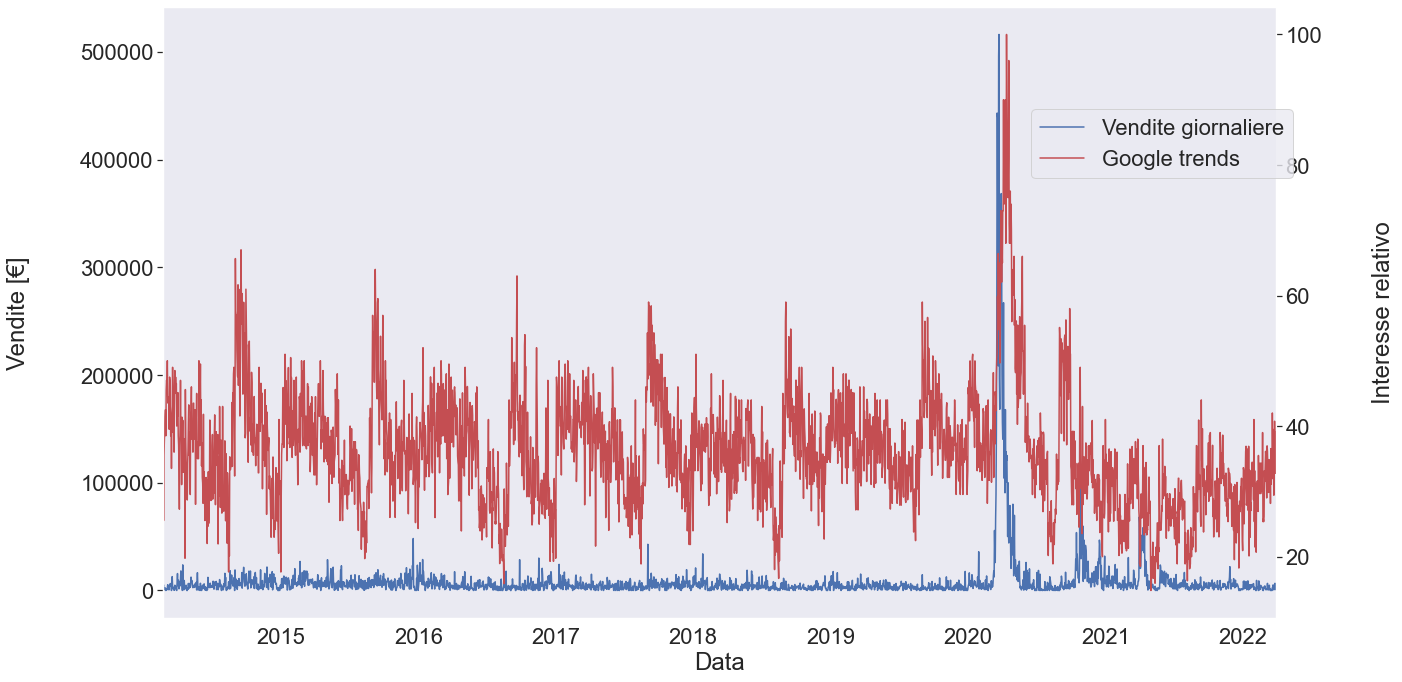

In [420]:
plt.rcParams['figure.figsize'] = 20, 10
sns.set(font_scale = 2)
ax = df_pivot_settore_and_data.reset_index().plot(x='data', y="Fitness", legend=False, label='Vendite giornaliere')
ax2 = ax.twinx()
df_trends.reset_index().plot(x='date', y='Fitness', ax=ax2, legend=False, color="r", label='Google trends')
ax.set_ylabel('Vendite [€]', labelpad=50)
ax2.set_ylabel('Interesse relativo', labelpad=50)
ax.figure.legend(loc='upper right', borderaxespad=5)
ax.set_xlabel('Data')
ax.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.show()

In [421]:
corr, _ = pearsonr(df_pivot_settore_and_data["Fitness"][:-7], df_trends["Fitness"])
corr

0.3275426710713026

##### Correlation with focus on covid period

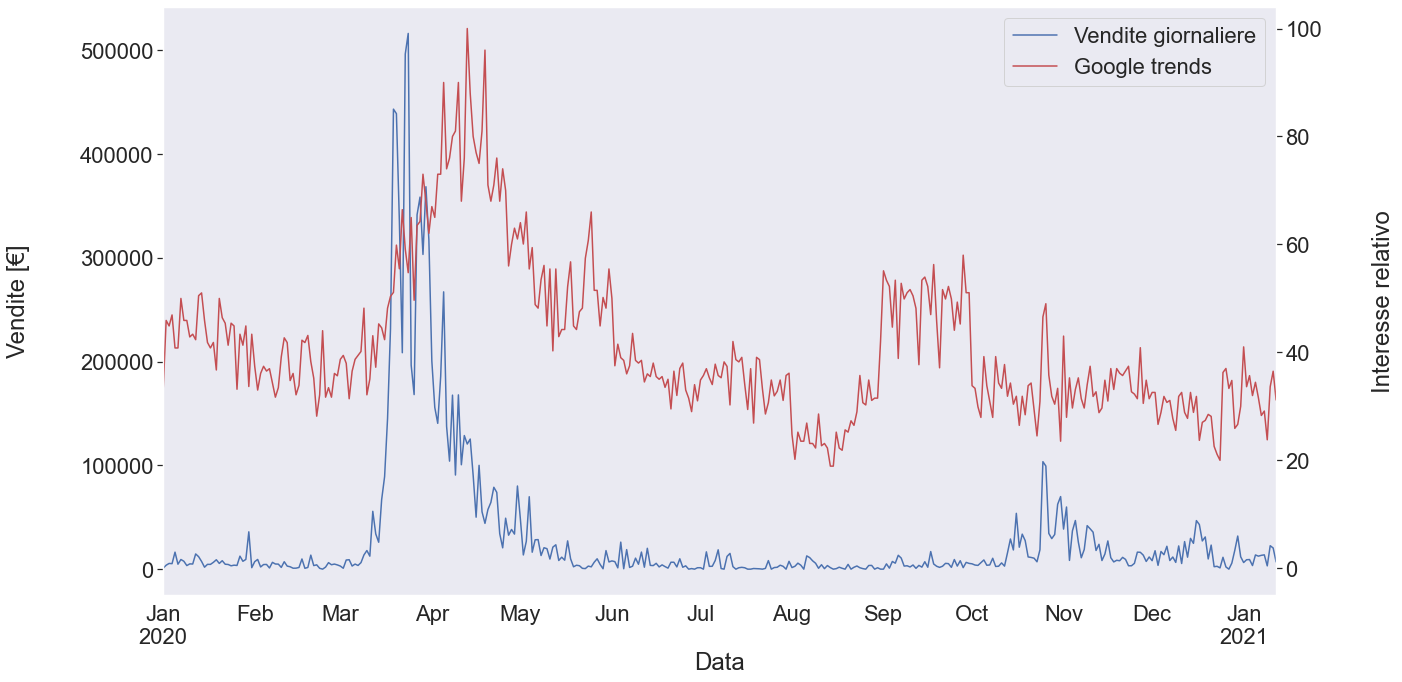

In [422]:
plt.rcParams['figure.figsize'] = 20, 10
ax = df_pivot_settore_and_data['01-01-2020':'01-12-2021'].reset_index().plot(x='data', y="Fitness", legend=False, label='Vendite giornaliere')
ax2 = ax.twinx()
df_trends['01-01-2020':'01-12-2021'].reset_index().plot(x='date', y='Fitness', ax=ax2, legend=False, color="r", label='Google trends')
ax.set_ylabel('Vendite [€]', labelpad=50)
ax2.set_ylabel('Interesse relativo', labelpad=50)
ax.set_ylim(-25000)
ax2.set_ylim(-5)
ax.set_xlabel('Data')
ax.grid(False)
ax2.grid(False)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.tight_layout()
plt.show()

In [423]:
corr, _ = pearsonr(df_pivot_settore_and_data['01-01-2020':'01-12-2021']["Fitness"], df_trends['01-01-2020':'01-12-2021']["Fitness"])
corr

0.48356557702180664

## Time series decomposition

### Decompose daily

In [424]:
sns.set(font_scale = 1.5)

In [425]:
df_sells_day_decomp = df_sells_day[(df_sells_day['data'] > '2014-02-20')]
df_sells_day_decomp = df_sells_day_decomp.set_index('data')

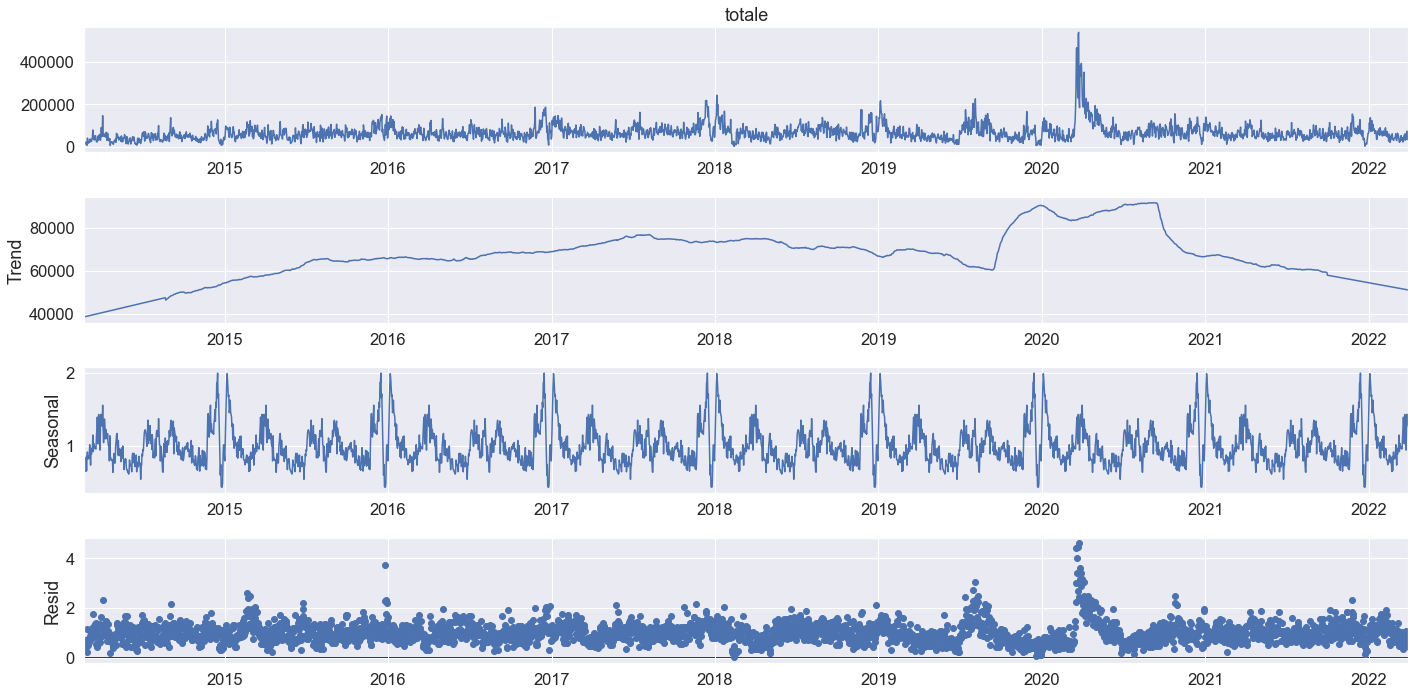

In [426]:
decompose_day = seasonal_decompose(df_sells_day_decomp['totale'], model='mul', period=365, extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (20,10)})
decompose_day.plot()
plt.show()

### Decompose weekly

In [427]:
df_sells_week.set_index('data', inplace=True)

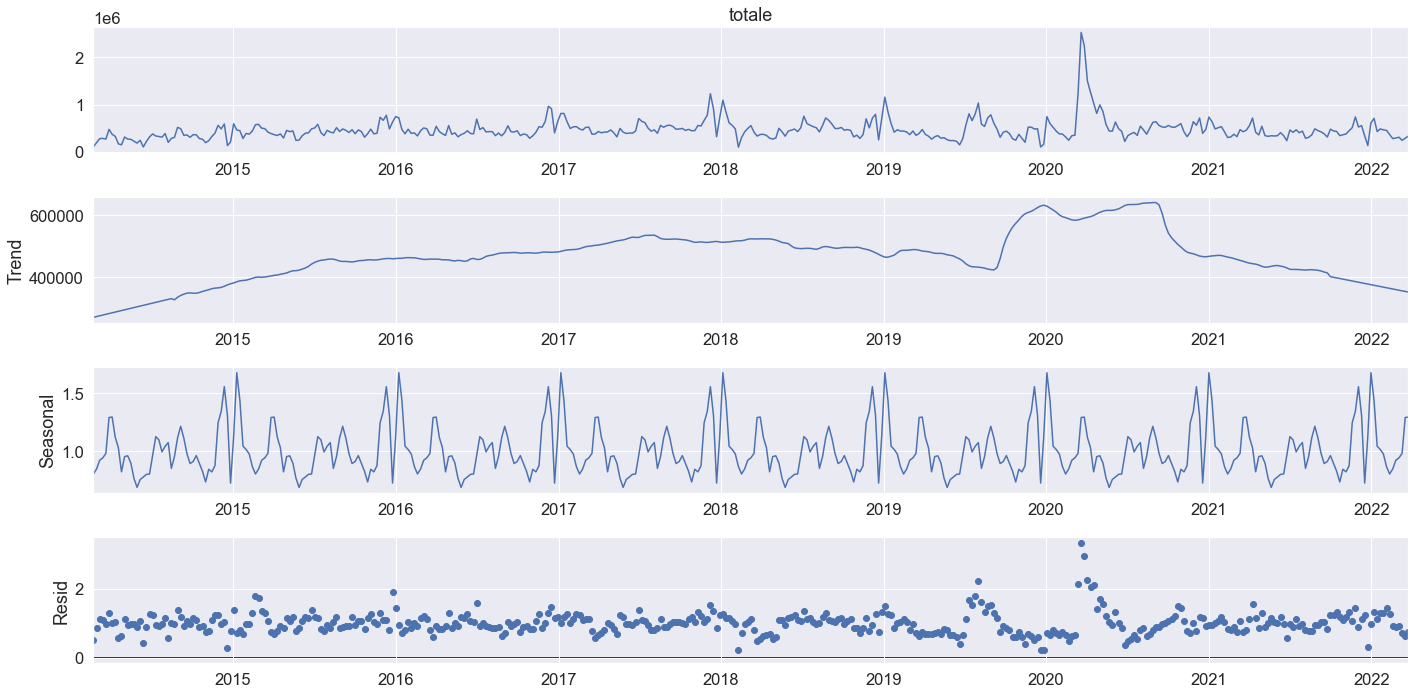

In [428]:
decompose_week = seasonal_decompose(df_sells_week['totale'], model='mul', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_week.plot()
plt.show()

### Decompose monthly

In [429]:
df_sells_month.set_index('data', inplace=True)

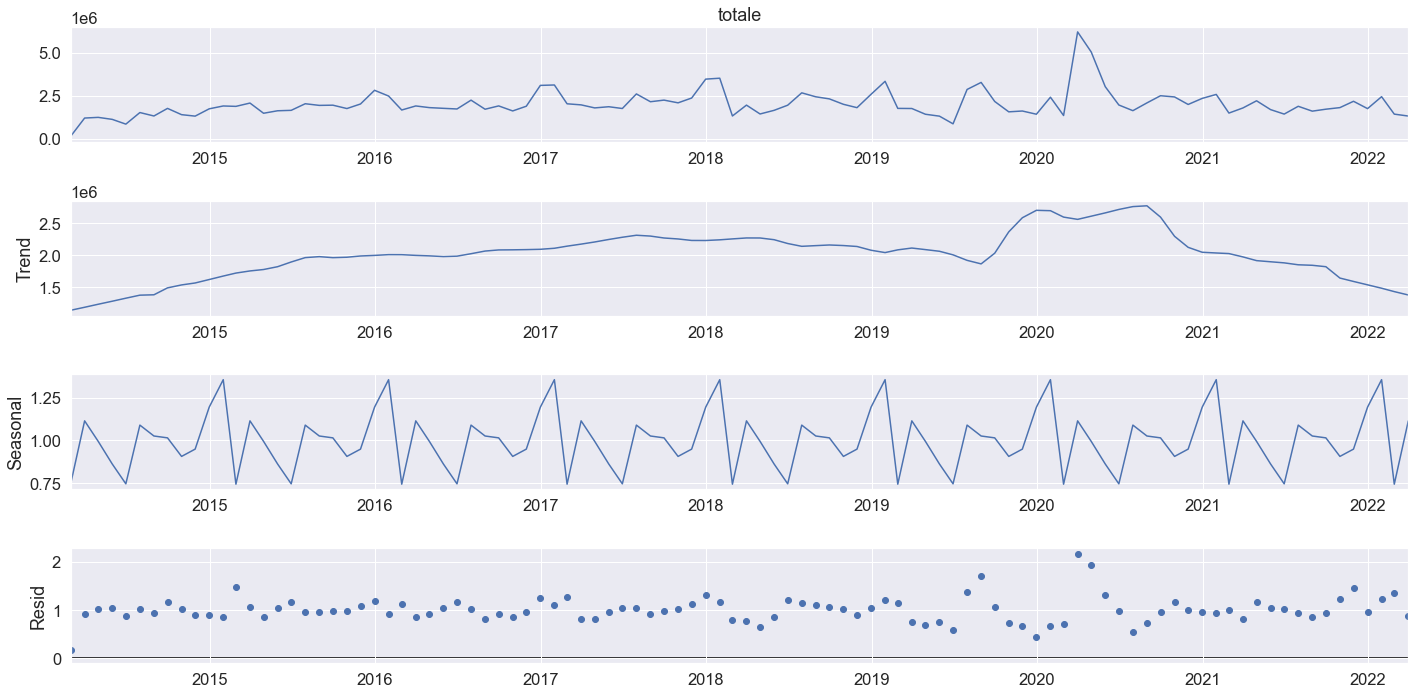

In [430]:
decompose_month = seasonal_decompose(df_sells_month['totale'], model='mul', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (20,10)})
decompose_month.plot()
plt.show()

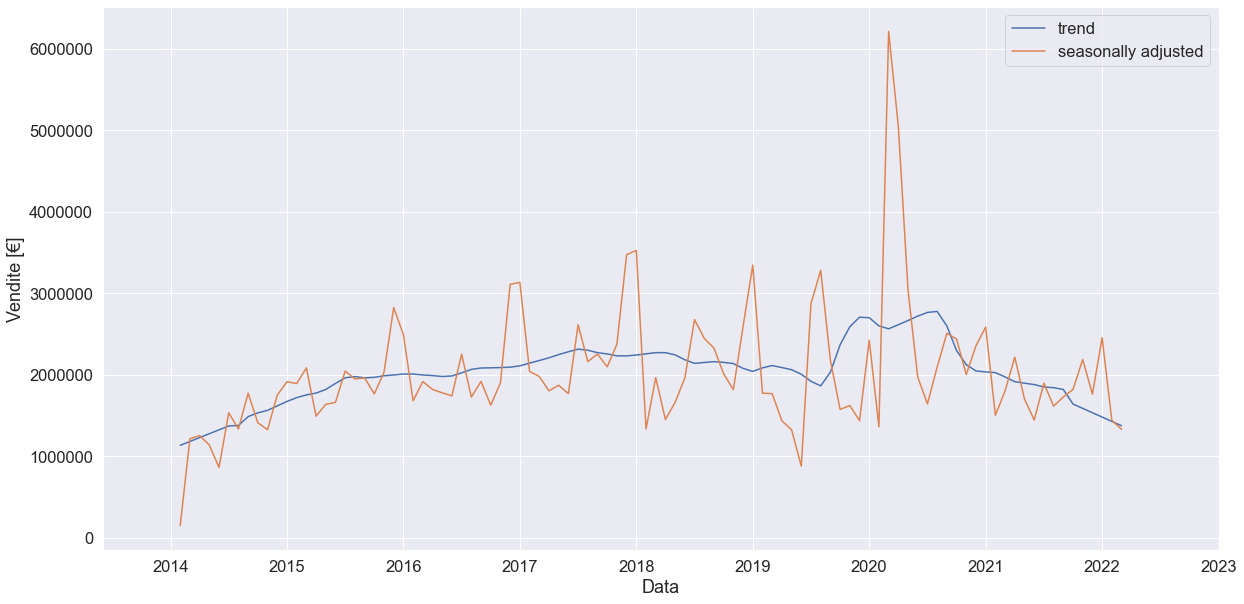

In [431]:
decompose_month.trend.plot()
classical_adjusted = (list(df_sells_month['totale']) - decompose_month.seasonal).rename('seasonally adjusted')
classical_adjusted.plot()
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(left='2013-06-06', right='2023-01-01')
plt.xlabel('Data')
plt.ylabel('Vendite [€]')
plt.legend()

In [432]:
months = {
    1:'Gen',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'Mag',
    6:'Giu',
    7:'Lug',
    8:'Ago',
    9:'Set',
    10:'Ott',
    11:'Nov',
    12:'Dic'
}

In [433]:
#seasonal = inv_boxcox(decompose_month.seasonal, lam)
seasonal = decompose_month.seasonal

avg_seasonal = seasonal.groupby(seasonal.index.month).mean()
avg_seasonal.index = avg_seasonal.index.map(months)
print(avg_seasonal.round(2))

data
Gen    1.36
Feb    0.74
Mar    1.11
Apr    0.99
Mag    0.86
Giu    0.75
Lug    1.09
Ago    1.03
Set    1.02
Ott    0.91
Nov    0.95
Dic    1.19
Name: seasonal, dtype: float64


(0.7, 1.4)

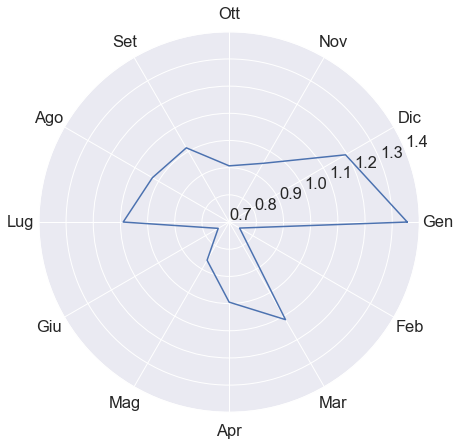

In [434]:
avg_seasonal_list = list(avg_seasonal.values)
avg_seasonal_list.append(avg_seasonal.values[0])

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot( projection='polar')

# 1. Plot the seasonal factors by day of week
theta = ((1 - np.arange(13) / 12) * 2 * np.pi)
ax1.plot(theta[:13], avg_seasonal_list)
ax1.set_xticks((1 - np.arange(12) / 12) * 2 * np.pi)
ax1.xaxis.set_tick_params(pad=5)
ax1.set_xticklabels(months.values())
ax1.set_ylim(0.7, 1.4)

## Time series analysis

### Model selection

#### FbProphet

In [435]:
df_fb = df_sells_week.reset_index().copy()
df_fb.columns = ['ds', 'y']

In [436]:
%%capture
param_grid = {  
    'changepoint_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_prior_scale': [0.05, 0.5, 1, 5, 10, 20, 30],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_fb[df_fb['ds'] < '2020-03-01'])  # Fit model with given params
    df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-02-28 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to ov

In [437]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results.iloc[np.argmin(mape)])

changepoint_prior_scale               1.0
seasonality_prior_scale               1.0
seasonality_mode           multiplicative
mape                             0.364617
Name: 32, dtype: object


In [438]:
df_fb_train = df_fb[df_fb['ds'] < '2018-06-01']
df_fb_test = df_fb[(df_fb['ds'] >='2018-06-01') & (df_fb['ds'] < '2020-03-01')]

In [439]:
model = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, seasonality_mode='multiplicative')
model.fit(df_fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [440]:
forecast = model.predict(df_fb_test)

c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


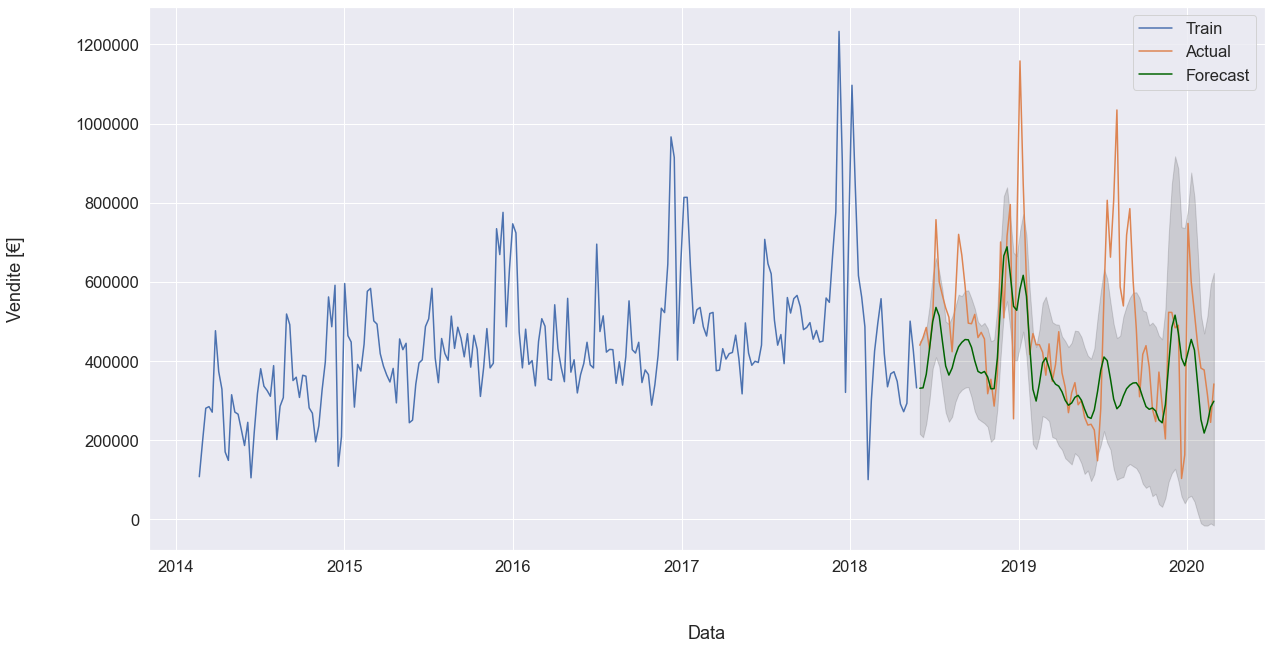

In [441]:
# Plot
fig, ax = plt.subplots()
train, = ax.plot(df_fb_train.set_index('ds')['y'], label='Train')
test, = ax.plot(df_fb_test.set_index('ds')['y'], label='Actual')
pred, = ax.plot(forecast.set_index('ds')['yhat'], color='darkgreen', label='Forecast')
ax.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.ticklabel_format(style='plain', axis='y')
ax.legend(handles=[train, test, pred])
plt.xlabel('Data', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.show()

In [442]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)       # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [443]:
forecast_accuracy(np.array(forecast['yhat']), np.array(df_fb_test['y']))

{'mape': 0.2872809948263151,
 'me': -92145.63556627734,
 'mae': 131378.51861910312,
 'mpe': -0.08474401982951706,
 'mse': 34772595601.94789,
 'rmse': 186474.11509898066,
 'corr': 0.5193174913019681,
 'minmax': 0.23636802021562886}

#### SARIMA

In [444]:
df_sells_month_train = df_sells_month[df_sells_month.index < '2019-01-01']
df_sells_month_test = df_sells_month[(df_sells_month.index > '2018-12-30') & (df_sells_month.index < '2021-12-31')]

In [445]:
smodel = pm.auto_arima(df_fb_train['y'], start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=52,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=4442.877, Time=2.60 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=4516.858, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=4478.351, Time=1.11 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=4449.891, Time=2.08 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=4463.138, Time=0.56 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=4444.854, Time=3.50 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=4444.843, Time=7.26 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=4445.069, Time=2.32 sec
 ARIMA(1,1,1)(1,1,2)[52]             : AIC=4446.463, Time=22.03 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=4473.115, Time=1.92 sec
 ARIMA(2,1,1)(0,1,1)[52]             : AIC=4439.143, Time=3.91 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=4462.817, Time=0.91 sec
 ARIMA(2,1,1)(1,1,1)[52]             : AIC=4441.113, Time=4.71 sec
 ARIMA(2,1,1)(0,1,2)[52]             : AIC=4441.105, Time=10.13 sec
 ARIMA(2,1,1)(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  223
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2211.266
Date:                            Wed, 25 May 2022   AIC                           4436.532
Time:                                    20:42:11   BIC                           4458.482
Sample:                                         0   HQIC                          4445.439
                                            - 223                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4903      0.086      5.715      0.000       0.322       0.658
ar.L2         -0.0766      0.131     -0.587      0.557      -0.333       0.179
ar.L3          0.1093      0.124      0.882      0.378      -0.134       0.352
ar.L4          0.2314      0.090      2.567      0.010       0.055       0.408
ma.L1         -0.9582      0.064    -14.917      0.000      -1.084      -0.832
ma.S.L52      -0.4207      0.091     -4.601      0.000      -0.600      -0.242
sigma2      1.323e+10   1.98e-12   6.69e+21      0.000    1.32e+10    1.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                38.36
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.26
Prob(H) (two-sided):                  0.43   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.53e+37. Standard errors may be unstable.
"""

In [446]:
# Forecast
n_periods = 92
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

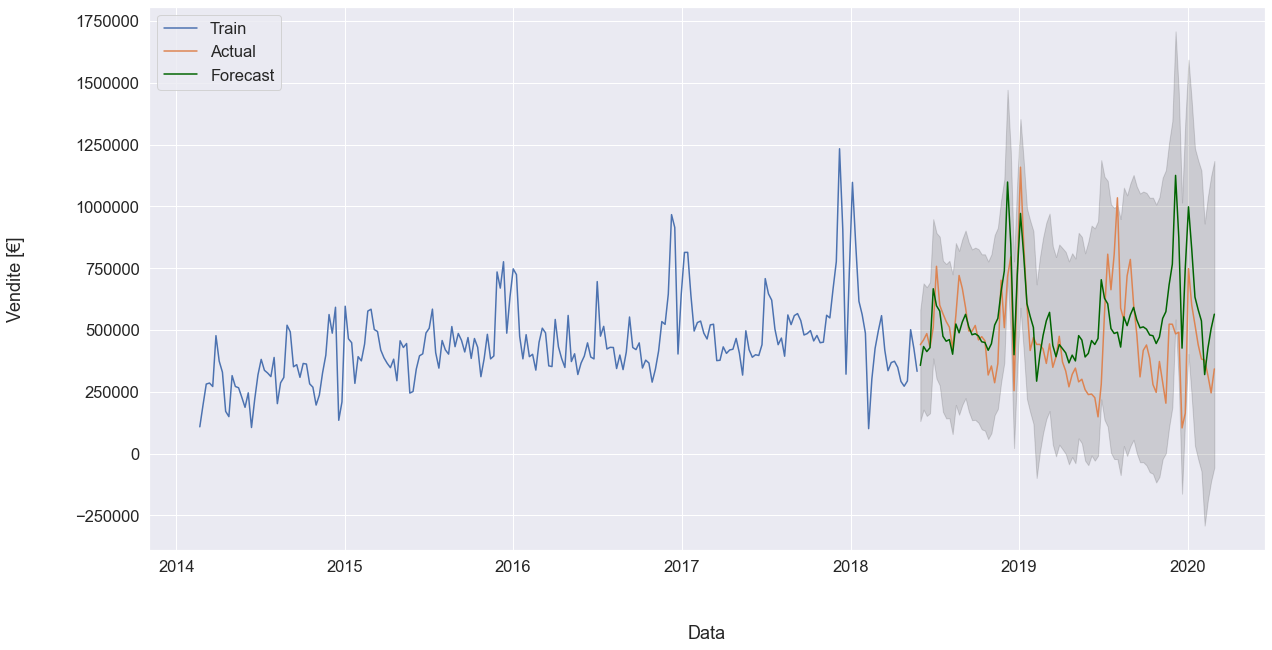

In [447]:
# Plot

# make series for plotting purpose
index_of_fc = list(df_fb_test['ds'])
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


fig, ax = plt.subplots()
train, = ax.plot(df_fb_train.set_index('ds')['y'], label='Train')
test, = ax.plot(df_fb_test.set_index('ds')['y'], label='Actual')
pred, = ax.plot(fitted_series, color='darkgreen', label='Forecast')
ax.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.ticklabel_format(style='plain', axis='y')
ax.legend(handles=[train, test, pred], loc='upper left')
plt.xlabel('Data', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.show()

In [448]:
forecast_accuracy(np.array(fitted), np.array(df_fb_test['y']))

{'mape': 0.42181896225228316,
 'me': 69660.35982304324,
 'mae': 145735.05380953714,
 'mpe': 0.31076999619451984,
 'mse': 37623455425.73706,
 'rmse': 193967.6659284662,
 'corr': 0.47054565566457746,
 'minmax': 0.24264424169034904}

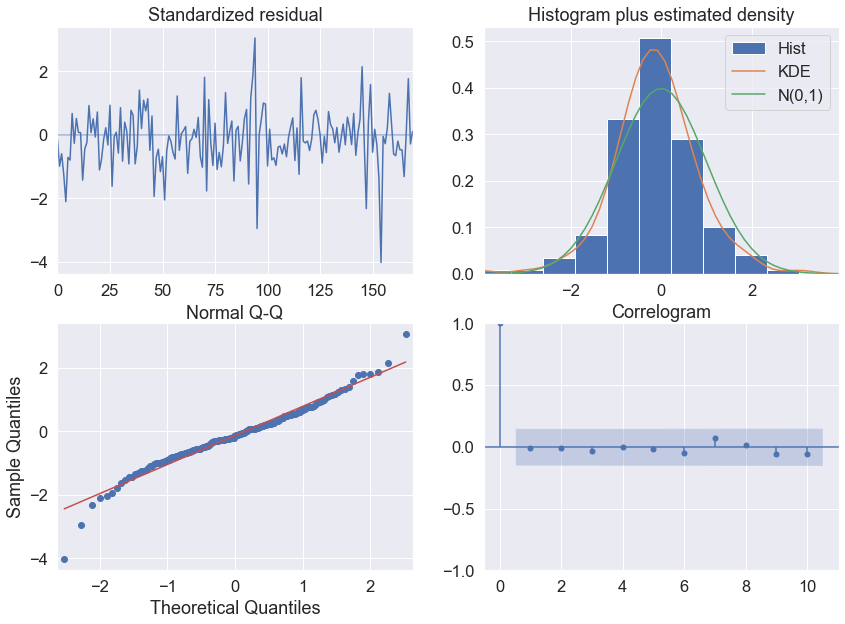

In [449]:
smodel.plot_diagnostics(figsize=(14,10))
plt.show()

### Covid impact analysis

In [450]:
df_fb_train = df_fb[df_fb['ds'] < '2020-01-01']
df_fb_test = df_fb[(df_fb['ds'] >= '2020-01-01') & (df_fb['ds'] < '2022-01-01')]

In [451]:
model = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, seasonality_mode='multiplicative')
model.fit(df_fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [452]:
forecast = model.predict(df_fb_test)

c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


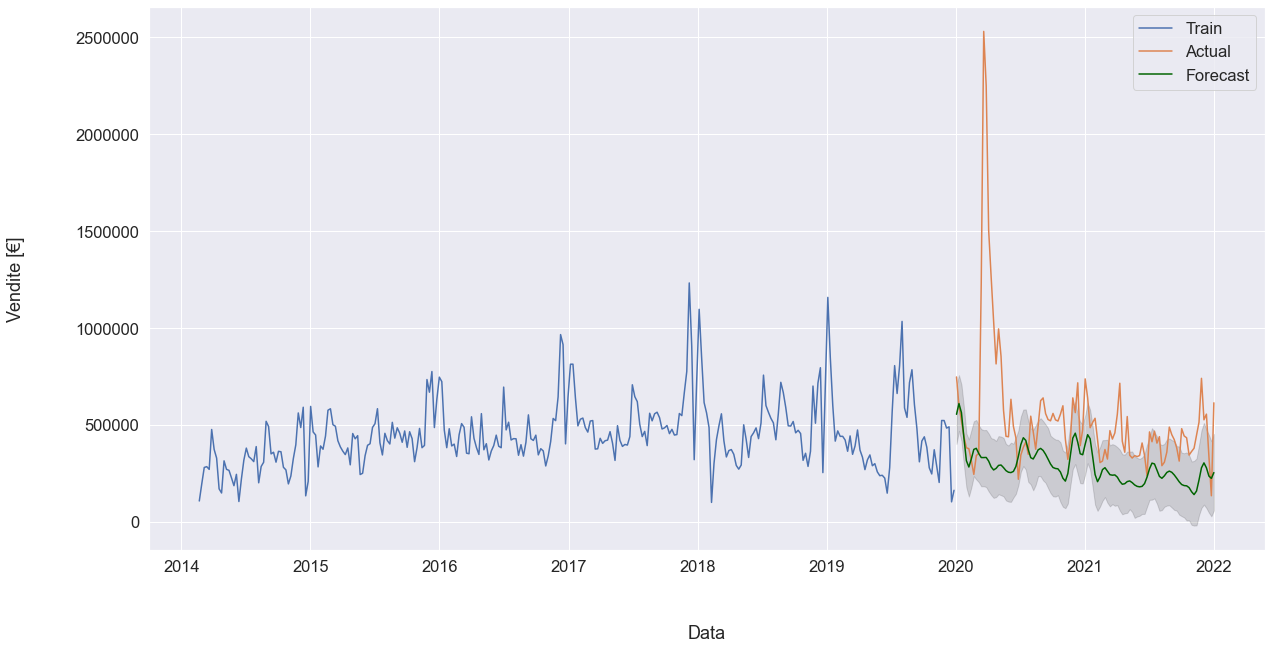

In [453]:
# Plot
fig, ax = plt.subplots()
train, = ax.plot(df_fb_train.set_index('ds')['y'], label='Train')
test, = ax.plot(df_fb_test.set_index('ds')['y'], label='Actual')
pred, = ax.plot(forecast.set_index('ds')['yhat'], color='darkgreen', label='Forecast')
ax.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.ticklabel_format(style='plain', axis='y')
ax.legend(handles=[train, test, pred])
plt.xlabel('Data', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.show()

In [454]:
sells_perc=(sum(df_fb_test['y'])-sum(forecast['yhat']))/sum(forecast['yhat'])*100
print('Vendite effettive superiori del ' + str(round(sells_perc)) + r'% rispetto alle vendite previste dal modello durante il periodo Covid (01/01/2020 - 31/12/2021)')

Vendite effettive superiori del 83% rispetto alle vendite previste dal modello durante il periodo Covid (01/01/2020 - 31/12/2021)


### Future forecast

In [455]:
model = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, seasonality_mode='multiplicative')
model.fit(df_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [456]:
future_dates = pd.date_range(list(df_fb['ds'])[-1], periods = 52, freq='W')
df_future = pd.DataFrame()
df_future['ds'] = future_dates

forecast = model.predict(df_future)

c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\Mattia\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


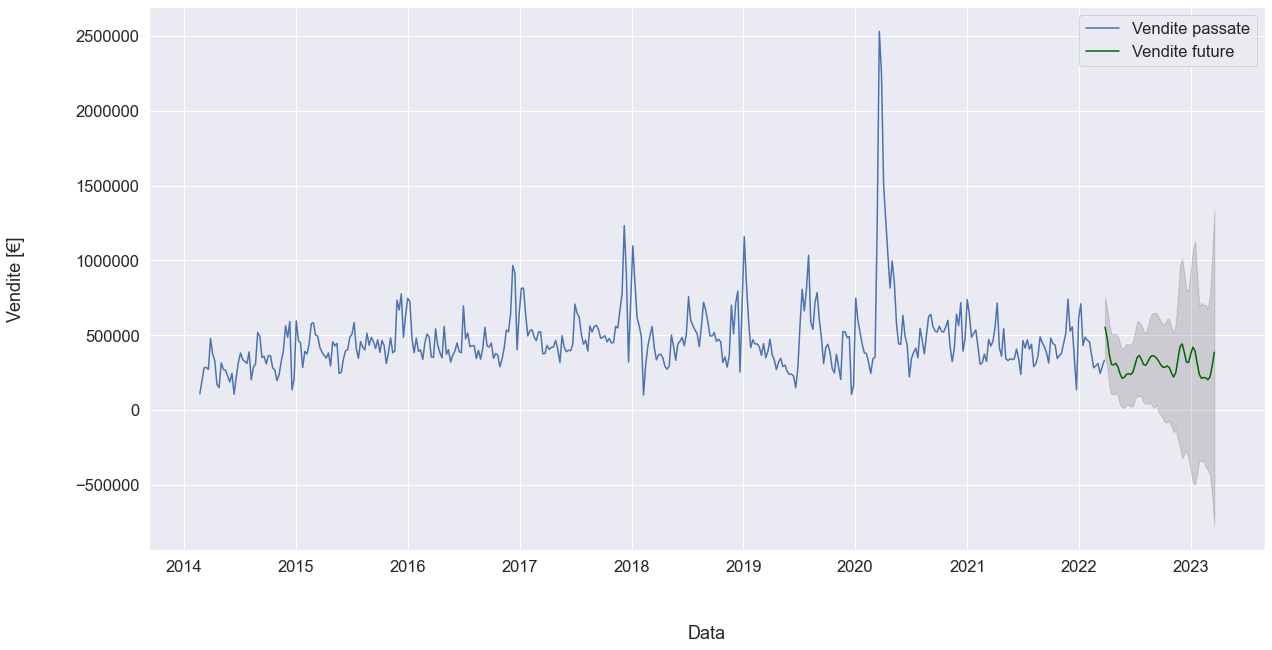

In [457]:
# Plot
fig, ax = plt.subplots()
train, = ax.plot(df_fb.set_index('ds')['y'], label='Vendite passate')
pred, = ax.plot(forecast.set_index('ds')['yhat'], color='darkgreen', label='Vendite future')
ax.fill_between(forecast.set_index('ds').index, 
                 forecast.set_index('ds')['yhat_lower'], 
                 forecast.set_index('ds')['yhat_upper'], 
                 color='k', alpha=.15)

plt.ticklabel_format(style='plain', axis='y')
ax.legend(handles=[train, pred])
plt.xlabel('Data', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.show()

In [458]:
forecast_2022 = forecast[['ds', 'yhat']].groupby(pd.Grouper(key='ds', freq='1m'))['yhat'].sum()['2022-03-31':'2022-12-31']

In [459]:
df_pivot_month[2022][3:12] = forecast_2022[1:].values

In [460]:
df_pivot_month[2022][2] = df_pivot_month[2022][2] + forecast_2022[0]

In [461]:
df_pivot_month.describe()

anno,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
mean,1.249578e+06,1.938444e+06,1.997196e+06,2.298046e+06,2.147691e+06,1.957926e+06,2.758411e+06,1.855226e+06,1.491914e+06
std,4.496960e+05,3.339884e+05,4.291439e+05,5.327952e+05,6.092255e+05,7.983349e+05,1.431321e+06,3.273135e+05,3.909546e+05
min,1.488231e+05,1.492607e+06,1.627219e+06,1.768157e+06,1.334476e+06,8.785999e+05,1.361682e+06,1.444479e+06,9.701993e+05
25%,1.175879e+06,1.740015e+06,1.737415e+06,1.952222e+06,1.778270e+06,1.436306e+06,1.995257e+06,1.681110e+06,1.316109e+06
50%,1.325950e+06,1.932309e+06,1.860432e+06,2.129405e+06,1.988325e+06,1.695611e+06,2.389943e+06,1.781493e+06,1.366607e+06
75%,1.472324e+06,2.034131e+06,2.002596e+06,2.436196e+06,2.483887e+06,2.350911e+06,2.641094e+06,1.969583e+06,1.512198e+06
max,1.774890e+06,2.825318e+06,3.109826e+06,3.473589e+06,3.526956e+06,3.347046e+06,6.214672e+06,2.585867e+06,2.454433e+06


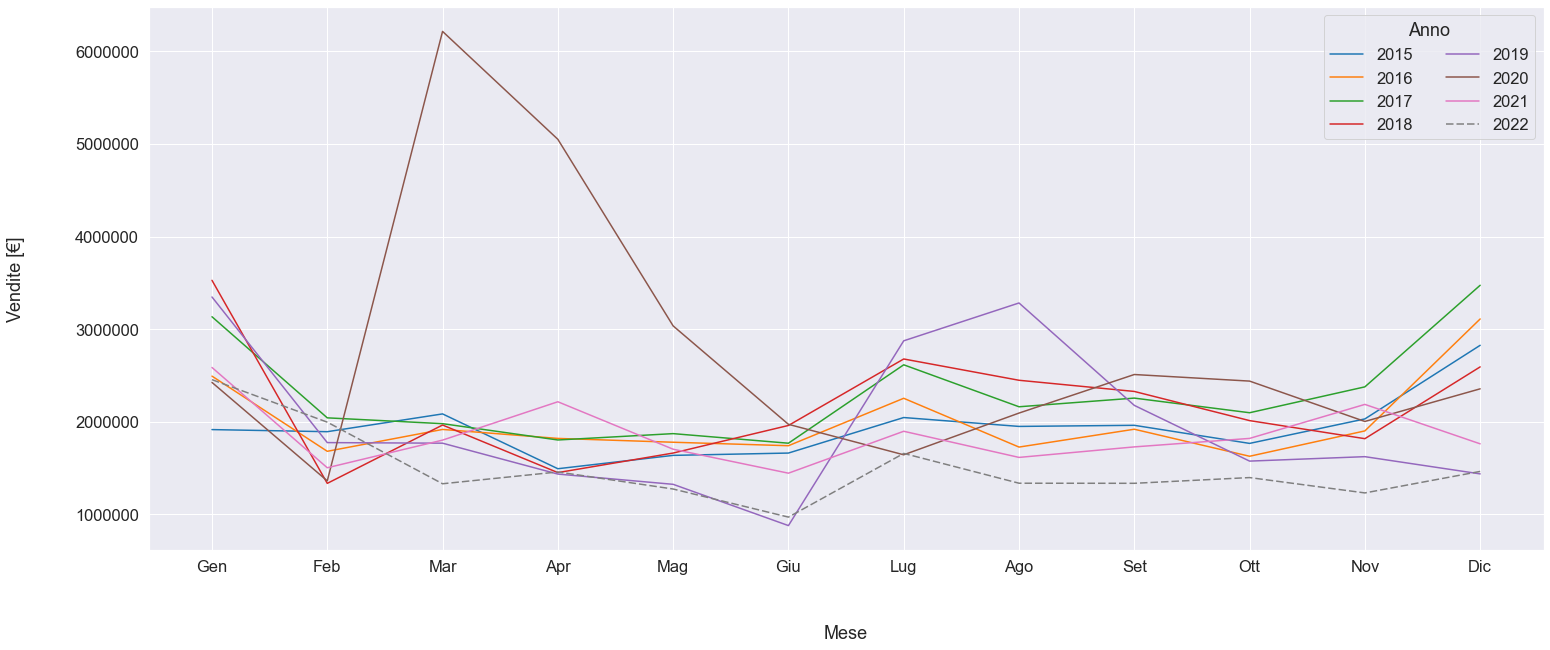

In [462]:
plt.figure(figsize=(25,10))
style = {key:'' for key in range(2015, 2022)}
style[2022] = (5, 2)
width = {key:1 for key in range(2015, 2022)}
width[2022] = 10
sns.lineplot(data=df_pivot_month[range(2015, 2023)], dashes=style, palette='tab10')
plt.xticks(df_pivot_month.index, labels=months.values());
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Mese', labelpad=50)
plt.ylabel('Vendite [€]', labelpad=50)
plt.legend(title='Anno', loc='upper right', ncol=2)
plt.show()